In [1]:
# imports
import os
from google.cloud import spanner
from datetime import datetime
import pprint
import re
import pandas as pd
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.3.0- is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# fetching database
spanner_client = spanner.Client()
spanner_instance_id = 'tfgen-spanid-20220525101635457'
spanner_database_id = 'metadata'
instance = spanner_client.instance(spanner_instance_id)
database = instance.database(spanner_database_id)

In [7]:
# fetch all states, districts, subdistricts, villages

# states
with database.snapshot() as snapshot:
  state_list = snapshot.execute_sql(
    """SELECT StateId, Name
    FROM States"""
  )

state_list = list(state_list)
states = {}
for state in state_list:
  states[state[0]] = state[1]

# districts
with database.snapshot() as snapshot:
  district_list = snapshot.execute_sql(
    """SELECT DistrictId, Name
    FROM districts"""
  )

district_list = list(district_list)
districts = {}
for district in district_list:
  districts[district[0]] = district[1]

# subdistricts
with database.snapshot() as snapshot:
  subdistrict_list = snapshot.execute_sql(
    """SELECT SubDistrictId, Name
    FROM SubDistricts"""
  )

subdistrict_list = list(subdistrict_list)
subdistricts = {}
for subdistrict in subdistrict_list:
  subdistricts[subdistrict[0]] = subdistrict[1]

# villages
with database.snapshot() as snapshot:
  village_list = snapshot.execute_sql(
    """SELECT VillageId, Name
    FROM Villages"""
  )

village_list = list(village_list)
villages = {}
for village in village_list:
  villages[village[0]] = village[1]

In [ ]:
# number of cards per district
with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    """SELECT DistrictId, COUNT(*)
    FROM Cards
    GROUP BY 1
    """
  )

data = list(data)
num_cards_district = {}
for dis in data:
  num_cards_district[dis[0]] = dis[1]

all_districts = []
for k,v in districts.items():
  all_districts.append((v , k))

all_districts.sort()
for dis in all_districts:
  print(dis[1])

In [4]:
# total number of cards extracted
with database.snapshot() as snapshot:
  total_cards = snapshot.execute_sql(
    """SELECT COUNT(*)
    FROM Cards_info"""
  )
total_cards = list(total_cards)
total_cards = total_cards[0][0]


In [6]:
# unit distribution all india
with database.snapshot() as snapshot:
  farm_size_unit = snapshot.execute_sql(
    """SELECT COUNT(*), farm_size_unit
    FROM Cards_info
    GROUP BY 2"""
  )
unit_all_india = list(farm_size_unit)

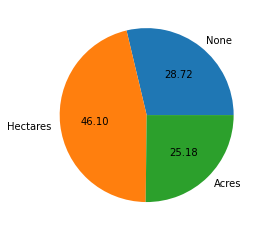

In [7]:
data = [unit_all_india[0][0]+unit_all_india[1][0], unit_all_india[2][0], unit_all_india[3][0]]
label = ['None', 'Hectares', 'Acres']
plt.pie(data, labels = label, autopct = '%.2f')
plt.show()

In [8]:
# unit distribution state
with database.snapshot() as snapshot:
  farm_size_unit = snapshot.execute_sql(
    """SELECT COUNT(*), StateId, farm_size_unit
    FROM Cards_info
    GROUP BY 2,3
    ORDER BY 2"""
  )

unit_state = list(farm_size_unit)

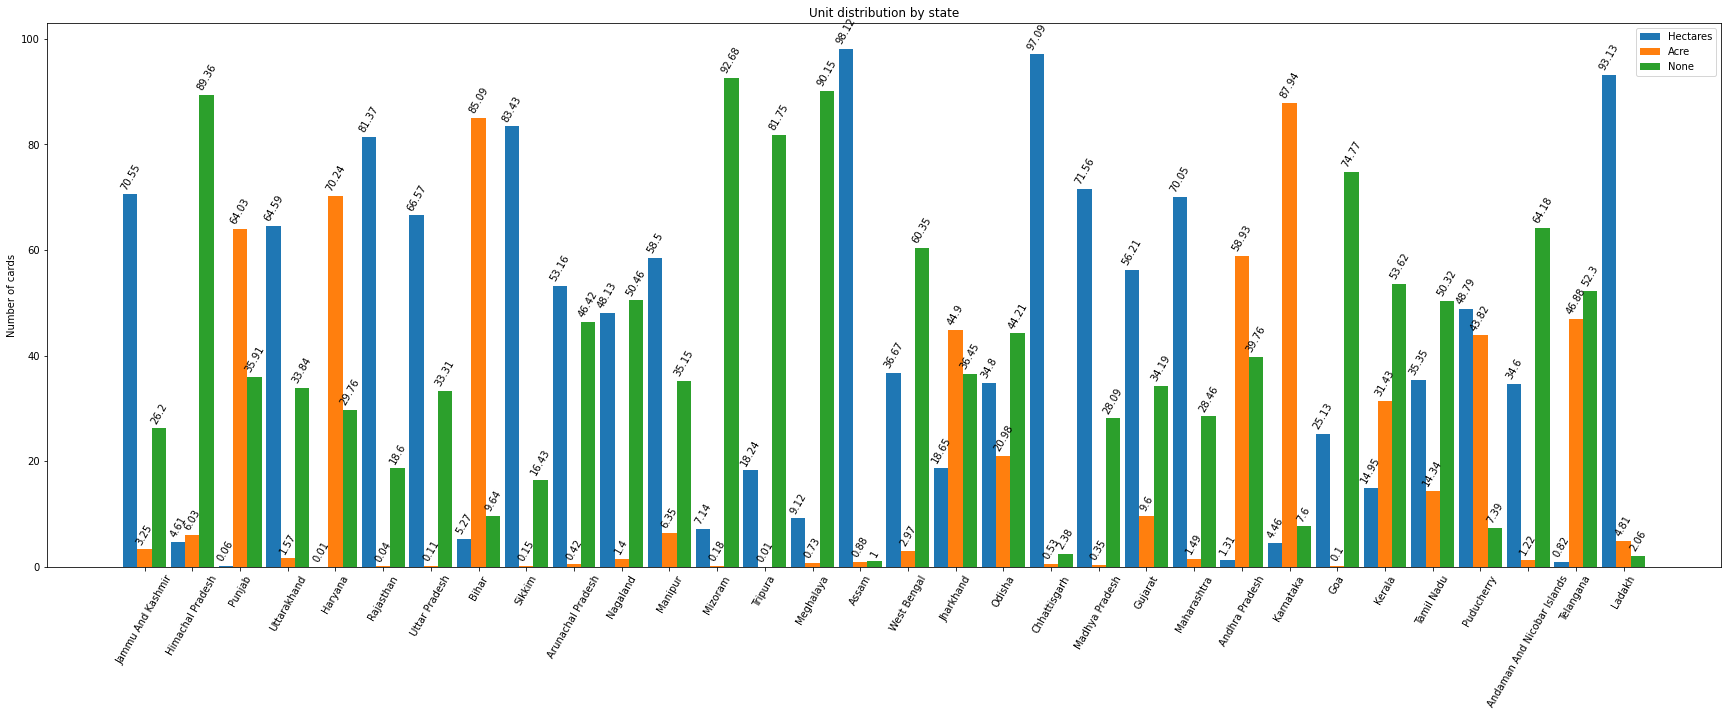

In [9]:
# unit distribution state wise plot
labels = []
acre = {}
hectares = {}
empty = {}
for row in unit_state:
  if row[1] not in labels:
    labels.append(row[1])
  if row[2] == 'Acre':
    acre[row[1]] = row[0]
  elif row[2] == 'Hectares':
    hectares[row[1]] = row[0]
  else:
    if empty.get(row[1]) is None:
      empty[row[1]] = 0
    empty[row[1]] += row[0]

labels = [states[i] for i in labels]
acre = list(acre.values())
hectares = list(hectares.values())
empty = list(empty.values())
# converting t percentages
for i in range(len(acre)):
  tot = acre[i] + hectares[i] + empty[i]
  acre[i] = round(acre[i]/tot*100, 2)
  hectares[i] = round(hectares[i]/tot*100, 2)
  empty[i] = round(empty[i]/tot*100, 2)

x = np.arange(len(labels))
width = 0.3  # the width of the bars
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(30)
rects1 = ax.bar(x - width, hectares, width, label='Hectares')
rects2 = ax.bar(x, acre, width, label='Acre')
rects3 = ax.bar(x + width, empty, width, label='None')

ax.set_ylabel('Number of cards')
ax.set_title('Unit distribution by state')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, rotation=60)
ax.bar_label(rects2, padding=3, rotation=60)
ax.bar_label(rects3, padding=3, rotation=60)
plt.xticks(rotation = 60)
plt.show()


In [10]:
# unit distribution district
with database.snapshot() as snapshot:
  farm_size_unit = snapshot.execute_sql(
    """SELECT COUNT(*), DistrictId, farm_size_unit
    FROM Cards_info
    GROUP BY 2,3
    ORDER BY 2"""
  )

unit_district = list(farm_size_unit)

In [11]:
# unit distribution village
with database.snapshot() as snapshot:
  farm_size_unit = snapshot.execute_sql(
    """SELECT COUNT(*), VillageId, farm_size_unit
    FROM Cards_info
    GROUP BY 2,3
    ORDER BY 2"""
  )

unit_village = list(farm_size_unit)

In [12]:
# soil test lab distribution
with database.snapshot() as snapshot:
  labs = snapshot.execute_sql(
    """SELECT COUNT(*), soil_test_lab
    FROM Cards_info
    Group by soil_test_lab"""
  )

labs = list(labs)

In [ ]:
# get all columns
with database.snapshot() as snapshot:
  cards_info_cols = snapshot.execute_sql(
    """SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'Cards_info'"""
  )

cards_info_cols = list(cards_info_cols)
cards_info_cols = [col[0] for col in cards_info_cols]
print(cards_info_cols)

In [61]:
cards_info_cols = ['soil_health_card_number', 'farm_size', 'irrigation_method', 'latitude', 'longitude', 'soil_test_lab', 'soil_type', 'pH_value', 'pH_rating', 'pH_min_normal_level', 'EC_value', 'EC_rating', 'EC_min_normal_level', 'OC_value', 'OC_rating', 'OC_min_normal_level', 'N_value', 'N_rating', 'N_min_normal_level', 'P_value', 'P_rating', 'P_min_normal_level', 'K_value', 'K_rating', 'K_min_normal_level', 'S_value', 'S_rating', 'S_min_normal_level', 'Zn_value', 'Zn_rating', 'Zn_min_normal_level', 'B_value', 'B_rating', 'B_min_normal_level', 'Fe_value', 'Fe_rating', 'Fe_min_normal_level', 'Mn_value', 'Mn_rating', 'Mn_min_normal_level', 'Cu_value', 'Cu_rating', 'Cu_min_normal_level', 'sample_collection_date']

In [ ]:
cards_info_cols = ['soil_health_card_number', 'farm_size', 'irrigation_method', 'latitude', 'longitude', 'soil_test_lab', 'soil_type', 'pH_value', 'pH_rating', 'pH_min_normal_level', 'EC_value', 'EC_rating', 'EC_min_normal_level', 'OC_value', 'OC_rating', 'OC_min_normal_level', 'N_value', 'N_rating', 'N_min_normal_level', 'P_value', 'P_rating', 'P_min_normal_level', 'K_value', 'K_rating', 'K_min_normal_level', 'S_value', 'S_rating', 'S_min_normal_level', 'Zn_value', 'Zn_rating', 'Zn_min_normal_level', 'B_value', 'B_rating', 'B_min_normal_level', 'Fe_value', 'Fe_rating', 'Fe_min_normal_level', 'Mn_value', 'Mn_rating', 'Mn_min_normal_level', 'Cu_value', 'Cu_rating', 'Cu_min_normal_level', 'sample_collection_date']

In [100]:
cards_info_cols = ['pH_value', 'EC_value', 'OC_value', 'N_value', 'P_value', 'K_value', 'S_value', 'Zn_value', 'B_value', 'Fe_value', 'Mn_value', 'Cu_value']

In [ ]:
# missing values all india
missing_values = {}
for col in cards_info_cols:
  if col == 'farm_size':
    with database.snapshot() as snapshot:
      data1 = snapshot.execute_sql(
        f"""SELECT COUNT(*)
        FROM Cards_info
        WHERE farm_size is Null
        OR farm_size_unit is Null
        OR CHAR_LENGTH(farm_size_unit) = 0"""
      )
  
  elif col == 'soil_type':
    with database.snapshot() as snapshot:
      data1 = snapshot.execute_sql(
        f"""SELECT COUNT(*)
        FROM Cards_info
        WHERE soil_type is Null
        OR CHAR_LENGTH(soil_type) = 0"""
      )
  
  else:
    with database.snapshot() as snapshot:
      data1 = snapshot.execute_sql(
        f"""SELECT COUNT(*)
        FROM Cards_info
        WHERE {col} is Null"""
      )
  
  data1 = list(data1)
  
  print(f'{col}: {data1[0][0]}/{total_cards} missing -> {round(data1[0][0]/total_cards*100, 2)}%')
  missing_values[col] = data1[0][0]

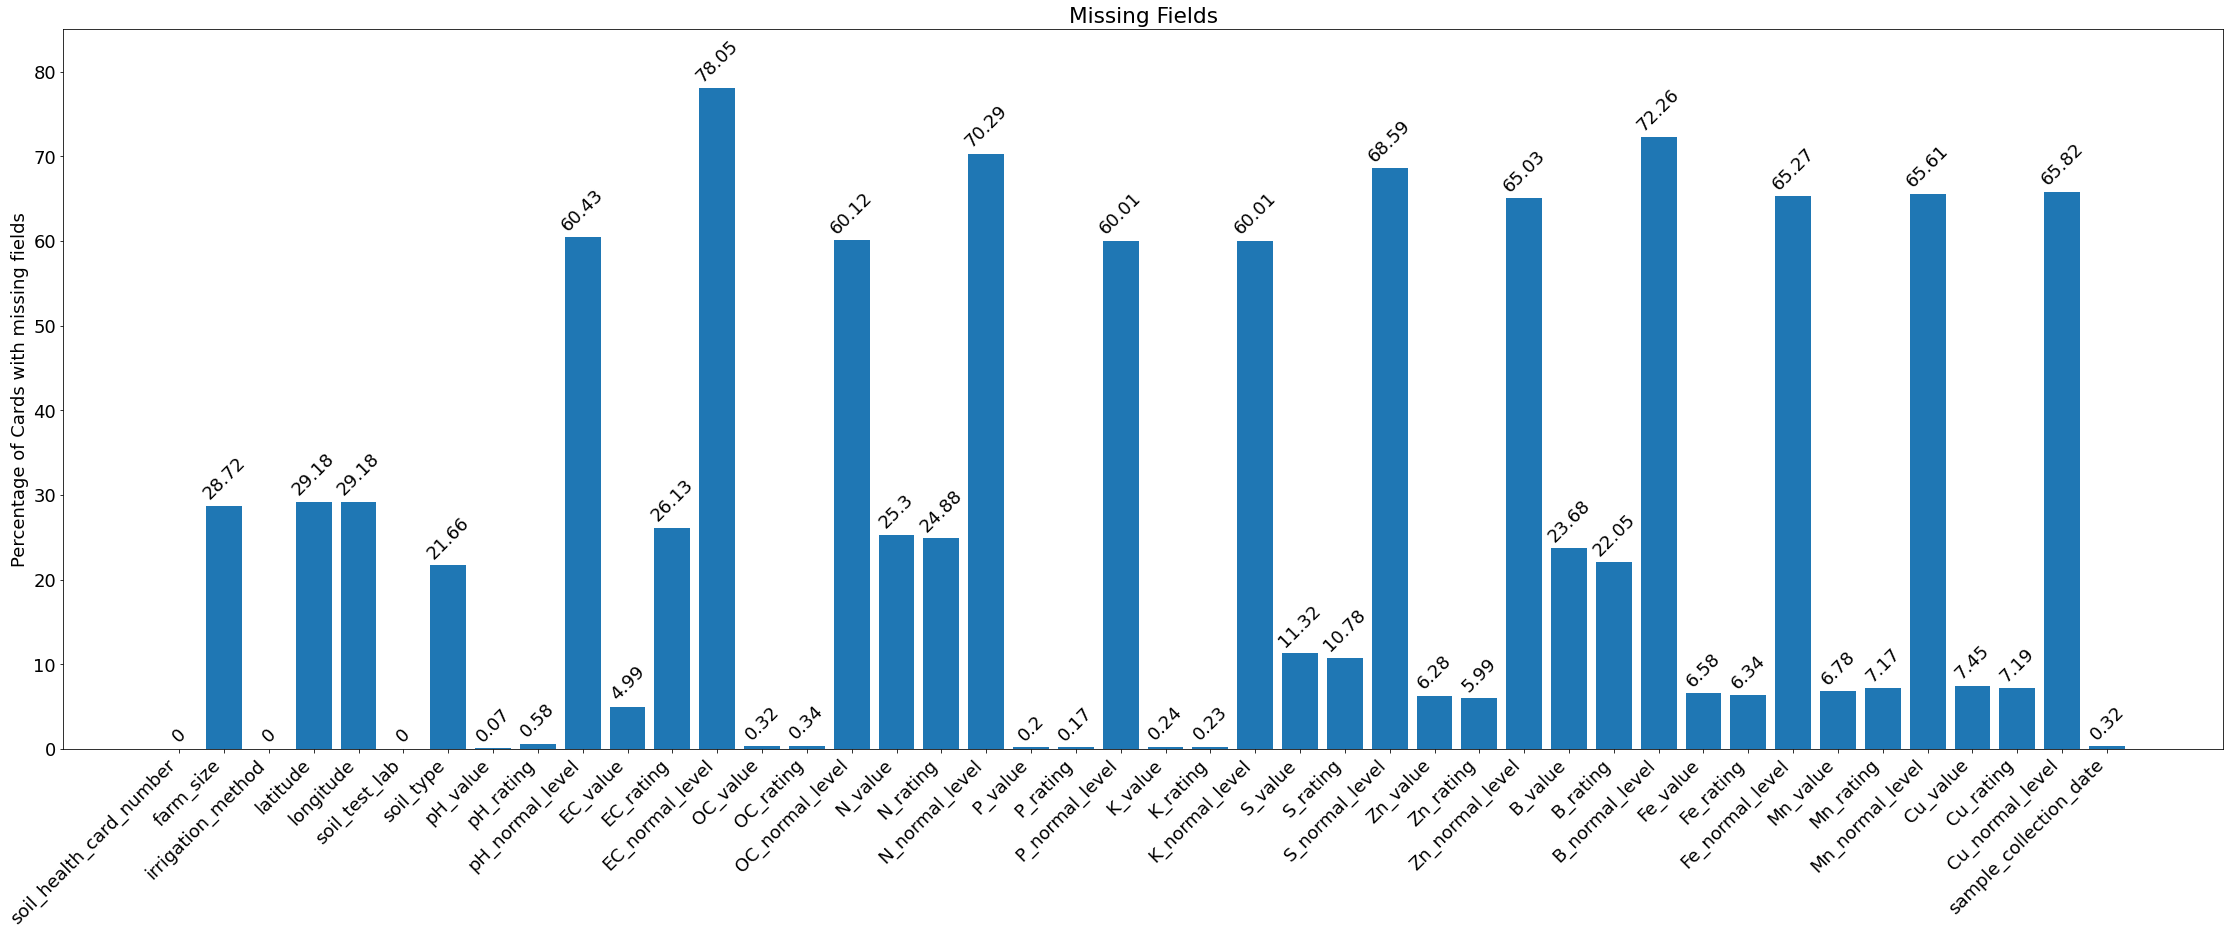

In [71]:
# missing values all india plot
parameters = ['soil_health_card_number', 'farm_size', 'irrigation_method', 'latitude', 'longitude', 'soil_test_lab', 'soil_type', 'pH_value', 'pH_rating', 'pH_normal_level', 'EC_value', 'EC_rating', 'EC_normal_level', 'OC_value', 'OC_rating', 'OC_normal_level', 'N_value', 'N_rating', 'N_normal_level', 'P_value', 'P_rating', 'P_normal_level', 'K_value', 'K_rating', 'K_normal_level', 'S_value', 'S_rating', 'S_normal_level', 'Zn_value', 'Zn_rating', 'Zn_normal_level', 'B_value', 'B_rating', 'B_normal_level', 'Fe_value', 'Fe_rating', 'Fe_normal_level', 'Mn_value', 'Mn_rating', 'Mn_normal_level', 'Cu_value', 'Cu_rating', 'Cu_normal_level', 'sample_collection_date']
missing_count = missing_values.values()
missing_count = [round(x/total_cards*100, 2) for x in missing_count]
mpl.rcParams.update({'font.size': 18})
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(30)
ax = fig.add_axes([0,0,1,1])
rect = ax.bar(parameters, missing_count)
ax.bar_label(rect, padding=3, rotation=45)
plt.xticks(rotation = 45, ha='right')
ax.set_ylabel('Percentage of Cards with missing fields')
ax.set_title('Missing Fields')
ax.set_ymargin(0.09)
plt.show()

In [ ]:
# missing values for only the 12 test values state wise
missing_values_state = {}
for col in cards_info_cols:
  with database.snapshot() as snapshot:
    data1 = snapshot.execute_sql(
      f"""SELECT StateId, COUNT(*)
      FROM Cards_info
      WHERE {col} is Null
      GROUP BY StateId
      ORDER BY StateId"""
    )
  data1 = list(data1)
  
  print(data1)
  missing_values_state[col] = data1

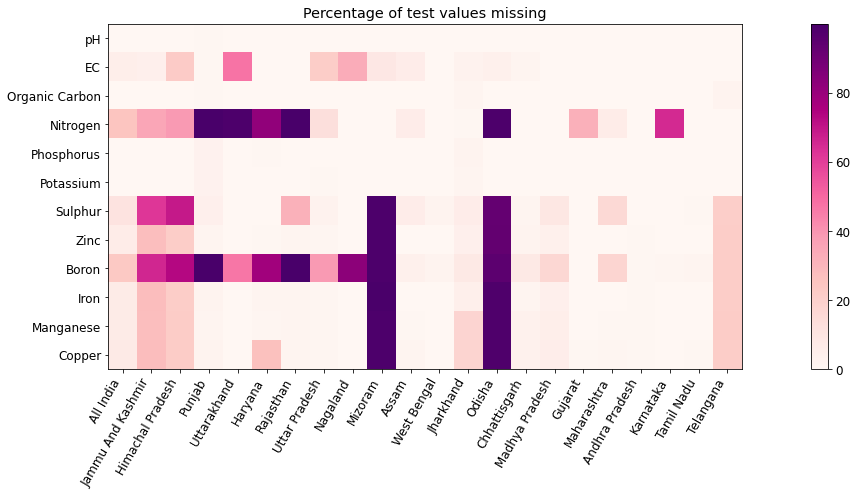

In [148]:
parameters = ['pH_value', 'EC_value', 'OC_value', 'N_value', 'P_value', 'K_value', 'S_value', 'Zn_value', 'B_value', 'Fe_value', 'Mn_value', 'Cu_value']
values = {}
for row, param in zip(missing_values_state.values(), parameters):
  vals = {}
  for item in row:
    vals[item[0]] = item[1]
  values[param] = vals


mpl.rcParams.update({'font.size': 12})
fig = plt.figure()
ax = fig.add_axes([0,0,3.2,1.2])
# ax.set_ylabel('Percentage of Cards with missing test values')
ax.set_title('Percentage of test values missing')
plt.xticks(rotation = 60, ha='right')

temp_states = {}
temp_states[0] = 'All India'
for k,v in states.items():
  if num_cards_state.get(k, 0) > 10000:
    temp_states[k] = v

labels = temp_states.values()
ylabels = ['pH', 'EC', 'Organic Carbon', 'Nitrogen', 'Phosphorus', 'Potassium', 'Sulphur', 'Zinc', 'Boron', 'Iron', 'Manganese', 'Copper']
datas = [[0 for _ in range(len(temp_states))] for _ in range(len(parameters))]
for i in range(len(parameters)):
  for j, x in zip(range(len(temp_states)), temp_states.keys()):
    if j==0:
      continue
    datas[i][j] = values[parameters[i]].get(x, 0)/num_cards_state[x]*100
    datas[i][0] += values[parameters[i]].get(x, 0)

for i in range(len(parameters)):
  datas[i][0] = datas[i][0]/total_cards*100

# for k,v in datas.items():
#   plt.scatter(labels, v, label=k, marker='$✓$', color='black')

# print(datas)
plt.imshow(datas, cmap='RdPu')

x0 = [105]*len(temp_states)
ax.set_ymargin(0)
# a0 = plt.bar(labels, x0, width=0.5, color=(0.4, 0.3, 0.2, 0.1))
# ax.legend(loc='best', framealpha=0.5)
# plt.grid(axis='y')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(parameters)))
ax.set_yticklabels(ylabels)
ax.set_xticklabels(labels, rotation=60, ha='right')
plt.colorbar()
plt.show()

In [19]:
with database.snapshot() as snapshot:
  test_values_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE pH_value is Null
    OR EC_value is Null
    OR OC_value is Null
    OR N_value is Null
    OR P_value is Null
    OR K_value is Null
    OR S_value is Null
    OR Zn_value is Null
    OR B_value is Null
    OR Fe_value is Null
    OR Mn_value is Null
    OR Cu_value is Null"""
  )

test_values_missing = list(test_values_missing)[0][0]
print(test_values_missing/total_cards*100)

41.008416497961434


In [20]:
with database.snapshot() as snapshot:
  test_min_normal_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE pH_min_normal_level is Null
    OR EC_min_normal_level is Null
    OR OC_min_normal_level is Null
    OR N_min_normal_level is Null
    OR P_min_normal_level is Null
    OR K_min_normal_level is Null
    OR S_min_normal_level is Null
    OR Zn_min_normal_level is Null
    OR B_min_normal_level is Null
    OR Fe_min_normal_level is Null
    OR Mn_min_normal_level is Null
    OR Cu_min_normal_level is Null"""
  )

test_min_normal_missing = list(test_min_normal_missing)[0][0]
print(test_min_normal_missing/total_cards*100)

84.78610797090298


In [21]:
with database.snapshot() as snapshot:
  test_rating_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE pH_rating is Null
    OR EC_rating is Null
    OR OC_rating is Null
    OR N_rating is Null
    OR P_rating is Null
    OR K_rating is Null
    OR S_rating is Null
    OR Zn_rating is Null
    OR B_rating is Null
    OR Fe_rating is Null
    OR Mn_rating is Null
    OR Cu_rating is Null"""
  )

test_rating_missing = list(test_rating_missing)[0][0]
print(test_rating_missing/total_cards*100)

51.66348130763818


In [22]:
with database.snapshot() as snapshot:
  test_soil_type_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(soil_type) = 0"""
  )

test_soil_type_missing = list(test_soil_type_missing)[0][0]
print(test_soil_type_missing/total_cards*100)

21.66301721559429


In [23]:
with database.snapshot() as snapshot:
  test_soil_test_lab_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(soil_test_lab) = 0"""
  )

test_soil_test_lab_missing = list(test_soil_test_lab_missing)[0][0]
print(test_soil_test_lab_missing/total_cards*100)

0.0


In [24]:
with database.snapshot() as snapshot:
  farm_size_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(farm_size_unit) = 0
    OR farm_size_unit is NULL
    OR farm_size is NULL"""
  )

farm_size_missing = list(farm_size_missing)[0][0]
print(farm_size_missing/total_cards*100)

28.71812670245727


In [25]:
with database.snapshot() as snapshot:
  geoposition_missing = snapshot.execute_sql(
    f"""SELECT COUNT(*)
    FROM Cards_info
    WHERE latitude is Null or longitude is Null"""
  )

geoposition_missing = list(geoposition_missing)[0][0]
print(geoposition_missing/total_cards*100)

29.176067861359495


In [26]:
missing_all_india = [test_values_missing, test_min_normal_missing, test_rating_missing, test_soil_type_missing, test_soil_test_lab_missing, farm_size_missing, geoposition_missing]
print(missing_all_india)

[1846780, 3818272, 2326622, 975576, 0, 1293297, 1313920]


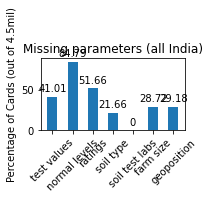

In [44]:
mpl.rcParams.update({'font.size': 10})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['test values', 'normal levels', 'ratings', 'soil type', 'soil test labs', 'farm size', 'geoposition']
vals = [round(x/total_cards*100, 2) for x in missing_all_india]
rect = ax.bar(labels, vals, width=0.5)
fig.set_figheight(1)
fig.set_figwidth(2)
ax.bar_label(rect, padding=3)
plt.xticks(rotation = 45)
ax.set_ylabel('Percentage of Cards (out of 4.5mil)')
ax.set_title('Missing parameters (all India)')
plt.show()

In [28]:
# number of cards per state
with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    """SELECT StateId, COUNT(*)
    FROM Cards_info
    GROUP BY StateId
    ORDER BY StateId"""
  )

data = list(data)
num_cards_state = {}
for x in data:
  num_cards_state[x[0]] = x[1]
print(num_cards_state)

{1: 196968, 2: 52773, 3: 69537, 5: 20925, 6: 74283, 8: 22466, 9: 785541, 10: 4365, 11: 8237, 12: 2135, 13: 15181, 14: 2000, 15: 28602, 16: 7620, 17: 5078, 18: 116825, 19: 27529, 20: 21970, 21: 132211, 22: 42505, 23: 1045153, 24: 106637, 27: 237311, 28: 245078, 29: 867712, 30: 2905, 32: 9918, 33: 321615, 34: 6735, 35: 6740, 36: 10607, 37: 6255}


In [ ]:
with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    GROUP BY soil_test_lab
    ORDER BY 2 DESC"""
  )

data = list(data)
num_cards_labs = {}
for x in data:
  num_cards_labs[x[0]] = x[1]
print(num_cards_labs)

In [30]:
with database.snapshot() as snapshot:
  data1 = snapshot.execute_sql(
    f"""SELECT StateId, COUNT(*)
    FROM Cards_info
    WHERE pH_value is Null
    OR EC_value is Null
    OR OC_value is Null
    OR N_value is Null
    OR P_value is Null
    OR K_value is Null
    OR S_value is Null
    OR Zn_value is Null
    OR B_value is Null
    OR Fe_value is Null
    OR Mn_value is Null
    OR Cu_value is Null
    GROUP BY StateId ORDER BY StateId"""
  )

data1 = list(data1)
test_values_missing_state = {}
for x in data1:
  test_values_missing_state[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT StateId, COUNT(*)
    FROM Cards_info
    WHERE pH_min_normal_level is Null
    OR EC_min_normal_level is Null
    OR OC_min_normal_level is Null
    OR N_min_normal_level is Null
    OR P_min_normal_level is Null
    OR K_min_normal_level is Null
    OR S_min_normal_level is Null
    OR Zn_min_normal_level is Null
    OR B_min_normal_level is Null
    OR Fe_min_normal_level is Null
    OR Mn_min_normal_level is Null
    OR Cu_min_normal_level is Null
    GROUP BY StateId ORDER BY StateId"""
  )

data = list(data)
test_min_normal_missing_state = {}
for x in data:
  test_min_normal_missing_state[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT StateId, COUNT(*)
    FROM Cards_info
    WHERE pH_rating is Null
    OR EC_rating is Null
    OR OC_rating is Null
    OR N_rating is Null
    OR P_rating is Null
    OR K_rating is Null
    OR S_rating is Null
    OR Zn_rating is Null
    OR B_rating is Null
    OR Fe_rating is Null
    OR Mn_rating is Null
    OR Cu_rating is Null
    GROUP BY StateId ORDER BY StateId"""
  )

data = list(data)
test_rating_missing_state = {}
for x in data:
  test_rating_missing_state[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT StateId, COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(soil_type) = 0
    GROUP BY StateId ORDER BY StateId"""
  )

data = list(data)
test_soil_type_missing_state = {}
for x in data:
  test_soil_type_missing_state[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT StateId, COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(farm_size_unit) = 0
    OR farm_size_unit is NULL
    OR farm_size is NULL
    GROUP BY StateId ORDER BY StateId"""
  )

data = list(data)
farm_size_missing_state = {}
for x in data:
  farm_size_missing_state[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT StateId, COUNT(*)
    FROM Cards_info
    WHERE latitude is Null or longitude is Null
    GROUP BY StateId ORDER BY StateId"""
  )

data = list(data)
geoposition_missing_state = {}
for x in data:
  geoposition_missing_state[x[0]] = x[1]

In [ ]:
test_values_missing_state[0] = test_values_missing
test_min_normal_missing_state[0] = test_min_normal_missing
test_rating_missing_state[0] = test_rating_missing
test_soil_type_missing_state[0] = test_soil_type_missing
farm_size_missing_state[0] = farm_size_missing
geoposition_missing_state[0] = geoposition_missing

print(test_values_missing_state)
print(test_min_normal_missing_state)
print(test_rating_missing_state)
print(test_soil_type_missing_state)
print(farm_size_missing_state)
print(geoposition_missing_state)

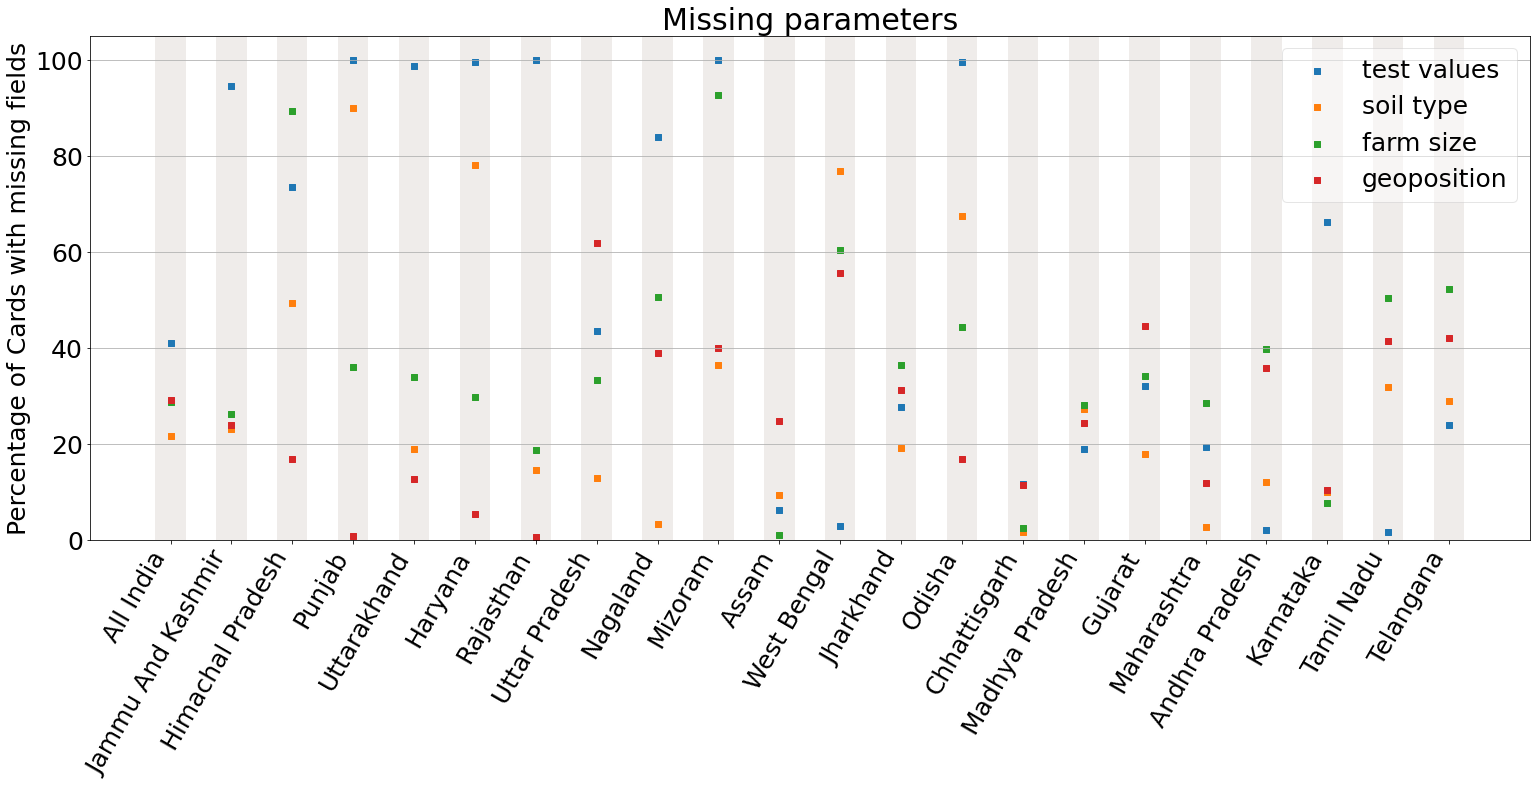

In [99]:
mpl.rcParams.update({'font.size': 25})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_figheight(7)
fig.set_figwidth(20)
ax.set_ylabel('Percentage of Cards with missing fields')
ax.set_title('Missing parameters')
plt.xticks(rotation = 60, ha='right')

temp_states = {}
temp_states[0] = 'All India'
for k,v in states.items():
  if num_cards_state.get(k, 0) > 10000:
    temp_states[k] = v

num_cards_state[0] = total_cards

labels = temp_states.values()
x0 = [105]*len(temp_states)
x1 = [round(test_values_missing_state.get(i, 0)/num_cards_state.get(i, 1)*100, 2) for i in temp_states.keys()]
x2 = [round(test_min_normal_missing_state.get(i, 0)/num_cards_state.get(i, 1)*100, 2) for i in temp_states.keys()]
x3 = [round(test_rating_missing_state.get(i, 0)/num_cards_state.get(i, 1)*100, 2) for i in temp_states.keys()]
x4 = [round(test_soil_type_missing_state.get(i, 0)/num_cards_state.get(i, 1)*100, 2) for i in temp_states.keys()]
x5 = [round(farm_size_missing_state.get(i, 0)/num_cards_state.get(i, 1)*100, 2) for i in temp_states.keys()]
x6 = [round(geoposition_missing_state.get(i, 0)/num_cards_state.get(i, 1)*100, 2) for i in temp_states.keys()]

ax.set_ymargin(0)
a0 = plt.bar(labels, x0, width=0.5, color=(0.4, 0.3, 0.2, 0.1))
a1 = plt.scatter(labels, x1, label='test values', marker='s')
# a2 = plt.plot(labels, x2, linewidth=5, label='normal levels')
# a3 = plt.plot(labels, x3, linewidth=5, label='ratings')
a4 = plt.scatter(labels, x4, label='soil type', marker='s')
a5 = plt.scatter(labels, x5, label='farm size', marker='s')
a6 = plt.scatter(labels, x6, label='geoposition', marker='s')
ax.legend(loc='best', framealpha=0.5)
plt.grid(axis='y')
plt.show()

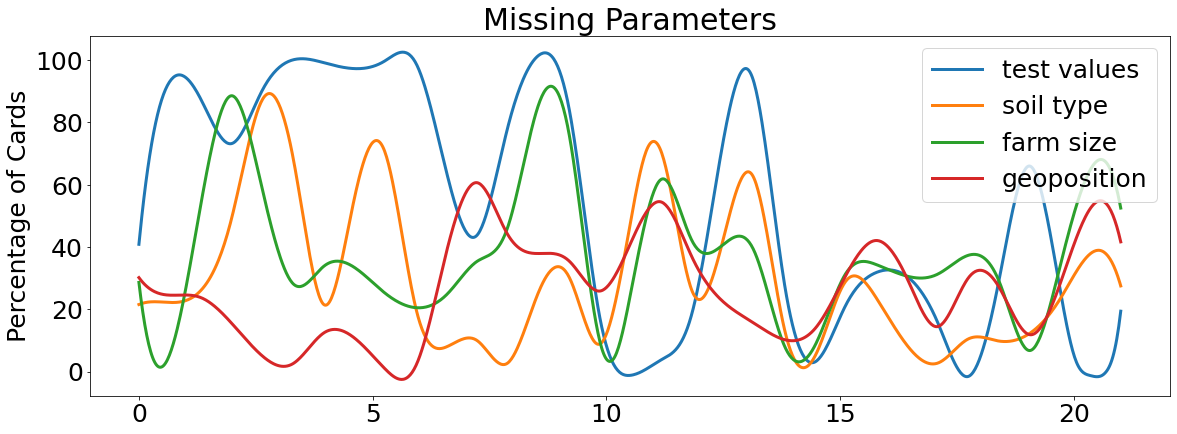

In [33]:
mpl.rcParams.update({'font.size': 25})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_figheight(5)
fig.set_figwidth(15)
ax.set_ylabel('Percentage of Cards')
ax.set_title('Missing parameters (Lab wise)')
# plt.xticks(rotation = 80)

from scipy.interpolate import UnivariateSpline

x = np.arange(len(labels))
labels_ = np.linspace(x.min(), x.max(), 1000)

x1_ = UnivariateSpline(x, x1)
x2_ = UnivariateSpline(x, x4)
x3_ = UnivariateSpline(x, x5)
x4_ = UnivariateSpline(x, x6)

ny1 = x1_(labels_).clip(0,max(x1_(x)))
ny2 = x2_(labels_).clip(0,max(x2_(x)))
ny3 = x3_(labels_).clip(0,max(x3_(x)))
ny4 = x4_(labels_).clip(0,max(x4_(x)))

y1_ = UnivariateSpline(labels_, ny1)
y2_ = UnivariateSpline(labels_, ny2)
y3_ = UnivariateSpline(labels_, ny3)
y4_ = UnivariateSpline(labels_, ny4)

plt.plot(labels_, y1_(labels_), lw=3, label='test values')
plt.plot(labels_, y2_(labels_), lw=3, label='soil type')
plt.plot(labels_, y3_(labels_), lw=3, label='farm size')
plt.plot(labels_, y4_(labels_), lw=3, label='geoposition')

plt.title("Missing Parameters")
# plt.xlabel("States")
plt.ylabel("Percentage of Cards")
ax.legend(loc='upper right')
# plt.grid()
plt.show()

In [34]:
with database.snapshot() as snapshot:
  data1 = snapshot.execute_sql(
    f"""SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE pH_value is Null
    OR EC_value is Null
    OR OC_value is Null
    OR N_value is Null
    OR P_value is Null
    OR K_value is Null
    OR S_value is Null
    OR Zn_value is Null
    OR B_value is Null
    OR Fe_value is Null
    OR Mn_value is Null
    OR Cu_value is Null
    GROUP BY soil_test_lab"""
  )

data1 = list(data1)
test_values_missing_lab = {}
for x in data1:
  test_values_missing_lab[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE pH_min_normal_level is Null
    OR EC_min_normal_level is Null
    OR OC_min_normal_level is Null
    OR N_min_normal_level is Null
    OR P_min_normal_level is Null
    OR K_min_normal_level is Null
    OR S_min_normal_level is Null
    OR Zn_min_normal_level is Null
    OR B_min_normal_level is Null
    OR Fe_min_normal_level is Null
    OR Mn_min_normal_level is Null
    OR Cu_min_normal_level is Null
    GROUP BY soil_test_lab ORDER BY soil_test_lab"""
  )

data = list(data)
test_min_normal_missing_lab = {}
for x in data:
  test_min_normal_missing_lab[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE pH_rating is Null
    OR EC_rating is Null
    OR OC_rating is Null
    OR N_rating is Null
    OR P_rating is Null
    OR K_rating is Null
    OR S_rating is Null
    OR Zn_rating is Null
    OR B_rating is Null
    OR Fe_rating is Null
    OR Mn_rating is Null
    OR Cu_rating is Null
    GROUP BY soil_test_lab ORDER BY soil_test_lab"""
  )

data = list(data)
test_rating_missing_lab = {}
for x in data:
  test_rating_missing_lab[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(soil_type) = 0
    GROUP BY soil_test_lab ORDER BY soil_test_lab"""
  )

data = list(data)
test_soil_type_missing_lab = {}
for x in data:
  test_soil_type_missing_lab[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(farm_size_unit) = 0
    OR farm_size_unit is NULL
    OR farm_size is NULL
    GROUP BY soil_test_lab ORDER BY soil_test_lab"""
  )

data = list(data)
farm_size_missing_lab = {}
for x in data:
  farm_size_missing_lab[x[0]] = x[1]

with database.snapshot() as snapshot:
  data = snapshot.execute_sql(
    f"""SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE latitude is Null or longitude is Null
    GROUP BY soil_test_lab ORDER BY soil_test_lab"""
  )

data = list(data)
geoposition_missing_lab = {}
for x in data:
  geoposition_missing_lab[x[0]] = x[1]

In [ ]:
print(len(test_values_missing_lab))
print(len(test_min_normal_missing_lab))
print(len(test_rating_missing_lab))
print(len(test_soil_type_missing_lab))
print(len(farm_size_missing_lab))
print(len(geoposition_missing_lab))

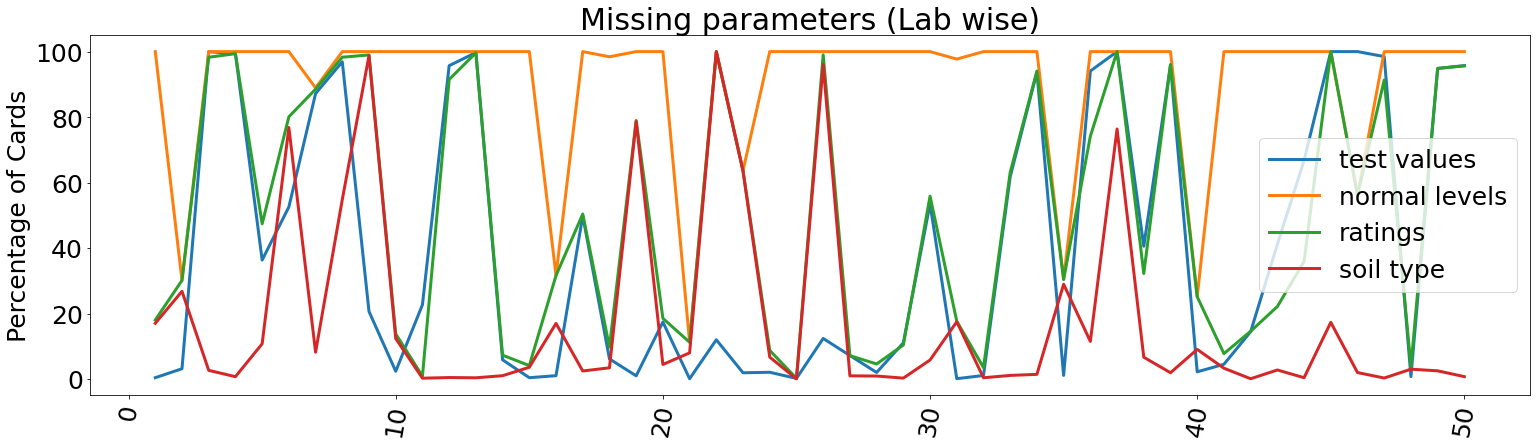

In [36]:
mpl.rcParams.update({'font.size': 25})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_figheight(5)
fig.set_figwidth(20)
ax.set_ylabel('Percentage of Cards')
ax.set_title('Missing parameters (Lab wise)')
plt.xticks(rotation = 80)


temp_labs = []
for k,v in num_cards_labs.items():
  if v > 10000:
    temp_labs.append(k)

temp_labs = temp_labs[:50]

labels = [i for i in range(1, 51)]
x1 = [round(test_values_missing_lab.get(i, 0)/num_cards_labs.get(i, 1)*100, 2) for i in temp_labs]
x2 = [round(test_min_normal_missing_lab.get(i, 0)/num_cards_labs.get(i, 1)*100, 2) for i in temp_labs]
x3 = [round(test_rating_missing_lab.get(i, 0)/num_cards_labs.get(i, 1)*100, 2) for i in temp_labs]
x4 = [round(test_soil_type_missing_lab.get(i, 0)/num_cards_labs.get(i, 1)*100, 2) for i in temp_labs]
x5 = [round(farm_size_missing_lab.get(i, 0)/num_cards_labs.get(i, 1)*100, 2) for i in temp_labs]
x6 = [round(geoposition_missing_lab.get(i, 0)/num_cards_labs.get(i, 1)*100, 2) for i in temp_labs]

a1 = plt.plot(labels, x1, linewidth=3, label='test values')
a2 = plt.plot(labels, x2, linewidth=3, label='normal levels')
a3 = plt.plot(labels, x3, linewidth=3, label='ratings')
a4 = plt.plot(labels, x4, linewidth=3, label='soil type')
# a5 = plt.plot(labels, x5, linewidth=3, label='farm size')
# a6 = plt.plot(labels, x6, linewidth=3, label='geoposition')

ax.legend(loc='best')
# plt.grid()
plt.show()


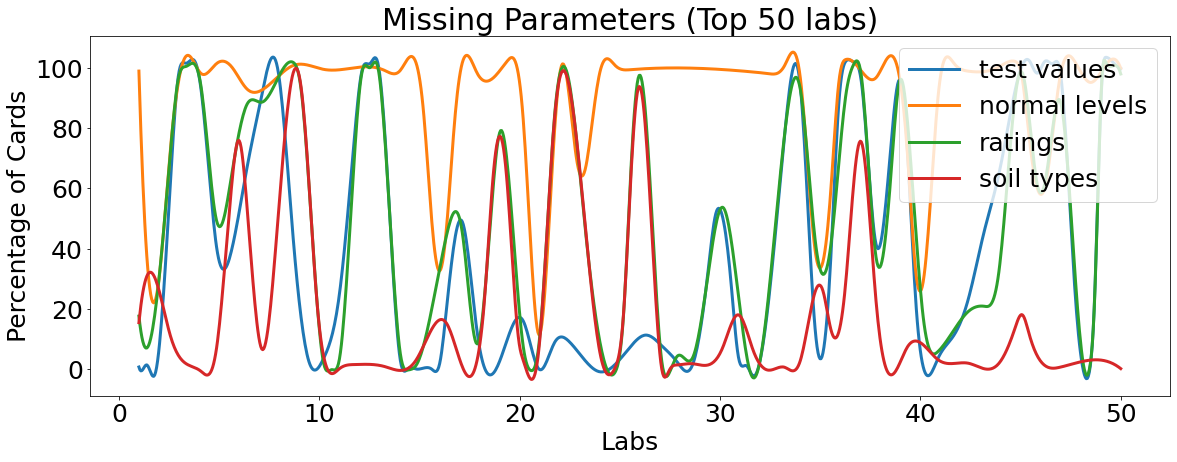

In [37]:
mpl.rcParams.update({'font.size': 25})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_figheight(5)
fig.set_figwidth(15)
ax.set_ylabel('Percentage of Cards')
ax.set_title('Missing parameters (Lab wise)')
# plt.xticks(rotation = 80)

from scipy.interpolate import UnivariateSpline

labels_ = np.linspace(1, 50, 1000)

x1_ = UnivariateSpline(labels, x1)
x2_ = UnivariateSpline(labels, x2)
x3_ = UnivariateSpline(labels, x3)
x4_ = UnivariateSpline(labels, x4)

ny1 = x1_(labels_).clip(0,max(x1_(labels)))
ny2 = x2_(labels_).clip(0,max(x2_(labels)))
ny3 = x3_(labels_).clip(0,max(x3_(labels)))
ny4 = x4_(labels_).clip(0,max(x4_(labels)))

y1_ = UnivariateSpline(labels_, ny1)
y2_ = UnivariateSpline(labels_, ny2)
y3_ = UnivariateSpline(labels_, ny3)
y4_ = UnivariateSpline(labels_, ny4)

plt.plot(labels_, y1_(labels_), lw=3, label='test values')
plt.plot(labels_, y2_(labels_), lw=3, label='normal levels')
plt.plot(labels_, y3_(labels_), lw=3, label='ratings')
plt.plot(labels_, y4_(labels_), lw=3, label='soil types')

plt.title("Missing Parameters (Top 50 labs)")
plt.xlabel("Labs")
plt.ylabel("Percentage of Cards")
ax.legend(loc='upper right')
# plt.grid()
plt.show()

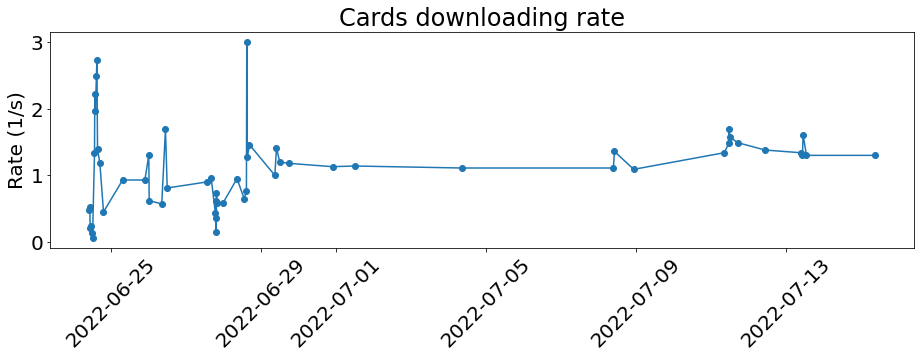

In [38]:
mpl.rcParams.update({'font.size': 20})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_figheight(3)
fig.set_figwidth(12)
ax.set_ylabel('Rate (1/s)')
ax.set_title('Cards downloading rate')
plt.xticks(rotation = 45)

from datetime import datetime

times = ['6/24/2022 9:54:00', '6/24/2022 10:15:00', '6/24/2022 10:23:00', '6/24/2022 10:54:00', '6/24/2022 11:27:00', '6/24/2022 11:56:00', '6/24/2022 13:12:00', '6/24/2022 13:24:00', '6/24/2022 13:49:00', '6/24/2022 14:25:00', '6/24/2022 14:45:00', '6/24/2022 15:08:00', '6/24/2022 16:37:00', '6/24/2022 18:58:00', '6/25/2022 7:14:00', '6/25/2022 21:28:00', '6/25/2022 23:59:00', '6/26/2022 0:14:00', '6/26/2022 8:17:00', '6/26/2022 10:40:00', '6/26/2022 11:47:00', '6/27/2022 13:00:00', '6/27/2022 15:57:00', '6/27/2022 18:41:00', '6/27/2022 19:07:00', '6/27/2022 19:10:00', '6/27/2022 19:16:00', '6/27/2022 19:20:00', '6/27/2022 19:36:00', '6/27/2022 23:40:00', '6/28/2022 8:30:00', '6/28/2022 13:05:00', '6/28/2022 14:32:00', '6/28/2022 14:45:00', '6/28/2022 15:05:00', '6/28/2022 16:30:00', '6/29/2022 8:44:00', '6/29/2022 9:48:00', '6/29/2022 11:54:00', '6/29/2022 17:54:00', '6/30/2022 21:44:00', '7/1/2022 11:51:00', '7/4/2022 8:39:00', '7/8/2022 9:39:00', '7/8/2022 10:18:00', '7/8/2022 22:37:00', '7/11/2022 8:44:00', '7/11/2022 11:29:00', '7/11/2022 11:38:00', '7/11/2022 12:26:00', '7/11/2022 17:26:00', '7/12/2022 10:50:00', '7/13/2022 9:35:00', '7/13/2022 10:47:00', '7/13/2022 11:11:00', '7/13/2022 13:20:00', '7/15/2022 9:07:00',]

rates = [0.48, 0.53, 0.21, 0.24, 0.13, 0.06, 1.33, 2.22, 1.97, 2.49, 2.74, 1.39, 1.19, 0.45, 0.93, 0.93, 1.30, 0.62, 0.57, 1.69, 0.81, 0.90, 0.96, 0.43, 0.15, 0.62, 0.36, 0.74, 0.59, 0.59, 0.95, 0.65, 0.76, 3.01, 1.27, 1.46, 1.00, 1.41, 1.20, 1.18, 1.13, 1.14, 1.11, 1.11, 1.36, 1.09, 1.34, 1.48, 1.69, 1.57, 1.49, 1.38, 1.34, 1.31, 1.61, 1.30, 1.30,]

dates = [datetime.strptime(date, '%m/%d/%Y %H:%M:%S') for date in times]

x = np.arange(len(rates))
spl = UnivariateSpline(x, rates)

# xs = np.linspace(min(dates), max(dates), 1000)
# start = pd.Timestamp('2022-06-23')
# end = pd.Timestamp('2022-07-16')
# xs = np.linspace(start.value, end.value, 100)
# xs = pd.to_datetime(xs)

# ny = spl(xs).clip(0,max(spl(x)))
# spl2 = UnivariateSpline(xs, ny)

plt.plot_date(dates, rates, linestyle ='solid')
# plt.plot_date(xs, spl2(xs))
# plt.yticks(range(0,3.5,0.5))
# plt.axis('scaled')
plt.show()



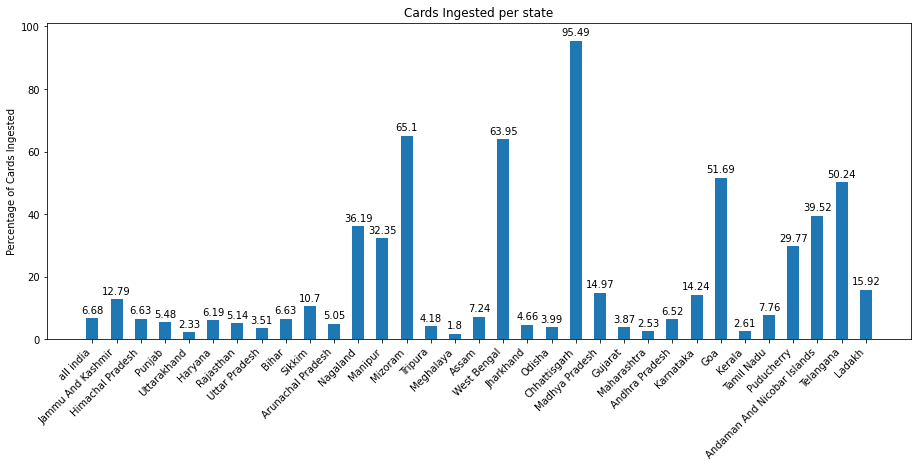

In [54]:
# print(states)

percent_ingested = [12.79, 6.63, 5.48, 0.00, 2.33, 6.19, 0.00, 5.14, 3.51, 6.63, 10.70, 5.05, 36.19, 32.35, 65.10, 4.18, 1.80, 7.24, 63.95, 4.66, 3.99, 95.49, 14.97, 3.87, 2.53, 6.52, 14.24, 51.69, 0.00, 2.61, 7.76, 29.77, 39.52, 50.24, 15.92]

labels = ['all india']
values = [6.68]
for name, percent in zip(states.values(), percent_ingested):
  if percent > 0:
    labels.append(name)
    values.append(percent)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1.1])
rect = ax.bar(labels, values, width=0.5)
ax.bar_label(rect, padding=3)
plt.xticks(rotation = 45, ha='right')
ax.set_ylabel('Percentage of Cards Ingested')
ax.set_title('Cards Ingested per state')
ax.set_ymargin(0.06)
plt.show()

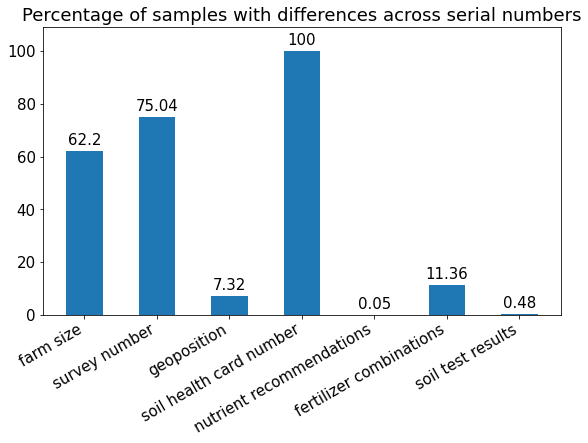

In [167]:
labels = ['farm size', 'survey number', 'geoposition', 'soil health card number', 'nutrient recommendations', 'fertilizer combinations', 'soil test results']
vals = [31098, 37522, 3659, 50000, 26, 5682, 241]
vals = [round(x/50000*100, 2) for x in vals]


mpl.rcParams.update({'font.size': 15})
fig = plt.figure()
ax = fig.add_axes([0,0,1.2,1])

rect = ax.bar(labels, vals, width=0.5)
ax.bar_label(rect, padding=3)
plt.xticks(rotation = 30, ha='right')
# ax.set_ylabel('Percentage')
ax.set_title('Percentage of samples with differences across serial numbers')
ax.set_ymargin(0.09)
plt.show()

In [ ]:
with database.snapshot() as snapshot:
  all_labs = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    GROUP BY 1 ORDER BY 1"""
  )
all_labs = list(all_labs)

######################################################################################################

with database.snapshot() as snapshot:
  tval_missing_labwise = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE pH_value is Null
    OR EC_value is Null
    OR OC_value is Null
    OR N_value is Null
    OR P_value is Null
    OR K_value is Null
    OR S_value is Null
    OR Zn_value is Null
    OR B_value is Null
    OR Fe_value is Null
    OR Mn_value is Null
    OR Cu_value is Null
    GROUP BY 1 ORDER BY 1"""
  )
tval_missing_labwise = list(tval_missing_labwise)
tval_missing_labwise = {x[0]:x[1] for x in tval_missing_labwise}

######################################################################################################

with database.snapshot() as snapshot:
  farmsize_missing_labwise = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE CHAR_LENGTH(farm_size_unit) = 0
    OR farm_size_unit is NULL
    OR farm_size is NULL
    GROUP BY 1 ORDER BY 1"""
  )
farmsize_missing_labwise = list(farmsize_missing_labwise)
farmsize_missing_labwise = {x[0]:x[1] for x in farmsize_missing_labwise}

######################################################################################################

with database.snapshot() as snapshot:
  geopos_missing_labwise = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE latitude is NULL
    OR longitude is NULL
    GROUP BY 1 ORDER BY 1"""
  )
geopos_missing_labwise = list(geopos_missing_labwise)
geopos_missing_labwise = {x[0]:x[1] for x in geopos_missing_labwise}

######################################################################################################

with database.snapshot() as snapshot:
  soiltype_missing_labwise = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE soil_type is NULL
    OR CHAR_LENGTH(soil_type) = 0
    GROUP BY 1 ORDER BY 1"""
  )
soiltype_missing_labwise = list(soiltype_missing_labwise)
soiltype_missing_labwise = {x[0]:x[1] for x in soiltype_missing_labwise}

######################################################################################################

with database.snapshot() as snapshot:
  any_missing_labwise = snapshot.execute_sql(
    """SELECT soil_test_lab, COUNT(*)
    FROM Cards_info
    WHERE pH_value is Null
    OR EC_value is Null
    OR OC_value is Null
    OR N_value is Null
    OR P_value is Null
    OR K_value is Null
    OR S_value is Null
    OR Zn_value is Null
    OR B_value is Null
    OR Fe_value is Null
    OR Mn_value is Null
    OR Cu_value is Null
    OR CHAR_LENGTH(farm_size_unit) = 0
    OR farm_size_unit is NULL
    OR farm_size is NULL
    OR latitude is NULL
    OR longitude is NULL
    OR soil_type is NULL
    OR CHAR_LENGTH(soil_type) = 0
    GROUP BY 1 ORDER BY 1"""
  )
any_missing_labwise = list(any_missing_labwise)
any_missing_labwise = {x[0]:x[1] for x in any_missing_labwise}

######################################################################################################

missing_data_labwise = {}
for lab in all_labs:
  missing_data_labwise[lab[0]] = {}
  missing_data_labwise[lab[0]]['num_cards'] = lab[1]
  missing_data_labwise[lab[0]]['tval'] = tval_missing_labwise.get(lab[0], 0)
  missing_data_labwise[lab[0]]['geopos'] = geopos_missing_labwise.get(lab[0], 0)
  missing_data_labwise[lab[0]]['soil_type'] = soiltype_missing_labwise.get(lab[0], 0)
  missing_data_labwise[lab[0]]['farm_size'] = farmsize_missing_labwise.get(lab[0], 0)
  missing_data_labwise[lab[0]]['any'] = something_missing_labwise.get(lab[0], 0)

missing_data_labwise = pd.DataFrame(missing_data_labwise).T